# DeepFashion (TFDS) – Image Classification with Keras/TensorFlow

This notebook trains a multi-class image classifier for **clothing categories** using the **DeepFashion (In-Shop Clothes Retrieval)** dataset from **TensorFlow Datasets**.  

### Introduction

This notebook presents the development of a **deep learning model for the automatic classification of clothing items from images**.  
The main objective is to enable the model to correctly identify the **category of each garment** given a dataset of labeled fashion product images.

This problem belongs to the field of **computer vision**, one of the most relevant areas in deep learning, with applications in **e-commerce** (such as the current challenge for the AI concentration), **visual product search**, and **personalized recommendation systems**.  

To achieve this, a **convolutional neural network (CNN)** based on **MobileNetV3Small** was implemented using TensorFlow and Keras.  
The network was trained and fine-tuned on the **Fashion Product Images (Small)** dataset from Kaggle, which contains thousands of labeled images of clothing and accessories.  
The goal is to evaluate the model’s performance, optimize it through fine-tuning, and test its ability to generalize to unseen data.



### Dataset and Preprocessing

The dataset used for this project is the **Fashion Product Images (Small)** dataset, available on Kaggle:  
👉 [Fashion Product Images (Small) – Param Aggarwal](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)

This dataset contains approximately **4,400 images** of clothing items and accessories from the online fashion store **Myntra**, along with a metadata file (`styles.csv`) describing each product.

#### Dataset description
Each record in the dataset includes:
- `id`: Unique identifier of the image file.
- `gender`: Intended gender for the product.
- `articleType`: Type or category of the clothing item (e.g., T-shirt, Shirt, Heels, Watch, etc.).
- `baseColour`: Main color of the item.
- `usage`: Suggested use or occasion (e.g., casual, formal).

#### Download and organization
The dataset was downloaded directly from Kaggle using the Kaggle API and extracted into a local directory.  
Images were organized into a folder structure compatible with TensorFlow, divided into three subsets:

data/
raw/fashion_small/
processed/fashion_kaggle_small
train/
val/
test/

#### Preprocessing steps
1. All images were resized to **224×224 pixels**.  
2. Pixel values were normalized to the range `[0, 1]`.  
3. A **train/validation/test split** was applied (80% / 10% / 10%).  
4. The top **10 most frequent categories** were selected to simplify the classification task and maintain balanced class distributions.  
5. Basic **data augmentation** techniques were used to improve generalization, including random horizontal flips, rotations, and zoom.



In [8]:
import os, math, json, shutil, itertools
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks

# seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("TF:", tf.__version__, "| Keras:", keras.__version__)

# Routes and constants
RAW_DIR = "data/raw/fashion_small"                   
CSV_PATH = os.path.join(RAW_DIR, "styles.csv")
IMAGES_DIR = os.path.join(RAW_DIR, "images")

# New output directory for processed data
DATA_ROOT = "data/processed/fashion_kaggle_small"
os.makedirs("data/processed", exist_ok=True)
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs("runs", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)

# Processing parameters
IMG_SIZE = (224, 224)
VAL_FRACTION = 0.10
TEST_FRACTION = 0.10      # global: ~80/10/10
BATCH = 16

def _safe_save_img(src_path, dst_path, size=IMG_SIZE):
    """Opens an image from src_path, resizes it to size and saves it as JPEG to dst_path."""
    try:
        with Image.open(src_path) as im:
            im = im.convert("RGB").resize(size)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            im.save(dst_path, format="JPEG", quality=95)
        return True
    except Exception:
        return False


TF: 2.20.0 | Keras: 3.12.0


### Data loading, class filtering, and stratified split

- **Load metadata:** We read `styles.csv` and keep only rows with non-null `id` and `articleType`.  
  Both fields are cast to `str` to ensure consistent joins with image filenames.

- **Category frequency & selection:** We compute the frequency of `articleType` and keep the **Top-10 most frequent categories** (`TOP_K=10`).  
  This reduces noise from very small classes and yields a more balanced multi-class problem while keeping the task realistic.

- **Shuffle:** We randomly shuffle the filtered dataframe with a fixed seed (`SEED=42`) for full reproducibility.

- **Split strategy (stratified):**
  1. First, a **test split** of `TEST_FRACTION = 0.10` is created with stratification by `articleType` to preserve class proportions.
  2. From the remaining 90%, we carve out a **validation split** such that the final proportions are **80/10/10** (train/val/test).  
- **Outputs:**  
  - `train_df`, `val_df`, `test_df` with their lengths printed for verification.  
  - Class counts shown before and after filtering to document the selected categories.


In [9]:
# Load csv 
df = pd.read_csv(CSV_PATH, on_bad_lines="skip")
df = df.dropna(subset=["id", "articleType"]).copy()
df["id"] = df["id"].astype(str)
df["articleType"] = df["articleType"].astype(str)

# Count by category
counts = df["articleType"].value_counts()
print("Total classes (articleType):", counts.shape[0])
display(counts.head(20))

# Filter classes 
TOP_K = 10
keep_classes = set(counts.head(TOP_K).index)

df = df[df["articleType"].isin(keep_classes)].sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Final Classes:", sorted(keep_classes))
display(df["articleType"].value_counts())
print("Total examples:", len(df))

# Split stratified
train_val_df, test_df = train_test_split(
    df, test_size=TEST_FRACTION, stratify=df["articleType"], random_state=SEED
)

# Of what remains, allocate validation set
val_size = VAL_FRACTION / (1 - TEST_FRACTION)
train_df, val_df = train_test_split(
    train_val_df, test_size=val_size, stratify=train_val_df["articleType"], random_state=SEED
)

len(train_df), len(val_df), len(test_df)



Total classes (articleType): 143


articleType
Tshirts                  7067
Shirts                   3217
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     609
Name: count, dtype: int64

Final Classes: ['Casual Shoes', 'Handbags', 'Heels', 'Kurtas', 'Shirts', 'Sports Shoes', 'Sunglasses', 'Tops', 'Tshirts', 'Watches']


articleType
Tshirts         7067
Shirts          3217
Casual Shoes    2845
Watches         2542
Sports Shoes    2036
Kurtas          1844
Tops            1762
Handbags        1759
Heels           1323
Sunglasses      1073
Name: count, dtype: int64

Total examples: 25468


(20374, 2547, 2547)

### Image export and directory structure

To make the dataset compatible with TensorFlow’s `image_dataset_from_directory()` API,  
the images are reorganized into a structured folder hierarchy based on their split and class.

In [10]:
# Clean output directories
for split in ["train", "val", "test"]:
    split_dir = os.path.join(DATA_ROOT, split)
    if os.path.exists(split_dir):
        shutil.rmtree(split_dir)

def _export_split(split_df, split_name):
    ok, bad = 0, 0
    for _, row in split_df.iterrows():
        img_id = row["id"]
        cls = row["articleType"]
        src = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
        dst = os.path.join(DATA_ROOT, split_name, cls, f"{cls}_{img_id}.jpg")
        if _safe_save_img(src, dst):
            ok += 1
        else:
            bad += 1
    print(f"{split_name}: guardadas={ok}, fallidas={bad}")

_export_split(train_df, "train")
_export_split(val_df, "val")
_export_split(test_df, "test")



train: guardadas=20372, fallidas=2
val: guardadas=2546, fallidas=1
test: guardadas=2547, fallidas=0


### Class distribution analysis

Before training, it is important to verify that the dataset remains **balanced** after preprocessing and exporting.

The function `class_distribution()`:
- Iterates through the class folders under the specified directory (`train`, in this case).
- Counts the number of image files (`.jpg`, `.jpeg`, `.png`) in each class subdirectory.
- Returns a Pandas `Series` sorted in descending order for inspection.
- Plots a **bar chart** using Matplotlib to visualize the class balance.

This step helps confirm that the top 10 selected categories remain reasonably balanced and that no class was disproportionately affected during preprocessing or export.

The plot titled **“Class distribution (train)”** provides a quick overview of how many training samples exist for each clothing type.


Tshirts         5652
Shirts          2572
Casual Shoes    2275
Watches         2034
Sports Shoes    1628
Kurtas          1476
Tops            1410
Handbags        1407
Heels           1059
Sunglasses       859
dtype: int64

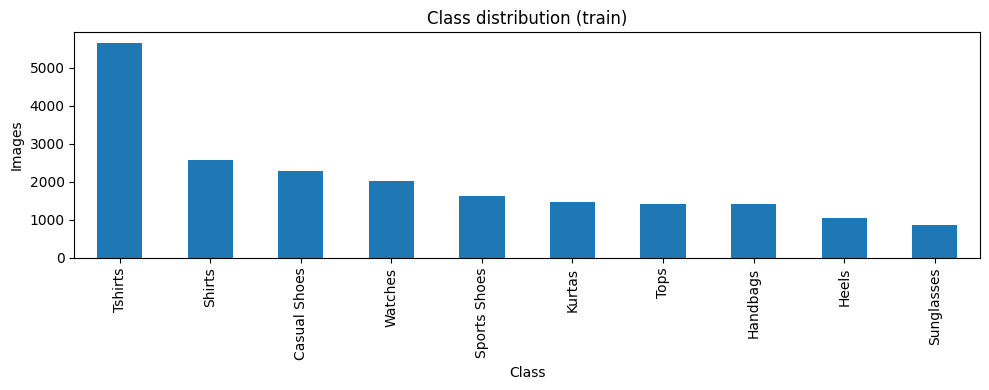

In [11]:
def class_distribution(root_dir):
    counts = {}
    for c in sorted(os.listdir(root_dir)):
        cdir = os.path.join(root_dir, c)
        if os.path.isdir(cdir):
            n = len([f for f in os.listdir(cdir) if f.lower().endswith((".jpg",".jpeg",".png"))])
            counts[c] = n
    s = pd.Series(counts).sort_values(ascending=False)
    display(s)
    # Plot
    plt.figure(figsize=(10,4))
    s.plot(kind="bar")
    plt.title("Class distribution (train)")
    plt.xlabel("Class")
    plt.ylabel("Images")
    plt.tight_layout()
    plt.show()
    return s

dist_train = class_distribution(os.path.join(DATA_ROOT, "train"))


### Dataset loading and augmentation pipeline

After exporting the images into a class-based directory structure, the next step is to create TensorFlow datasets for efficient training.

**Function: `load_ds()`**
- **Purpose:** Loads the train and validation datasets from the processed directory and applies real-time image augmentation.
- **Implementation details:**
  - Uses `keras.utils.image_dataset_from_directory()` to automatically label subfolders by class name.
  - Images are resized to **224×224** and batched (`batch_size=16`).
  - Labels are returned in **categorical (one-hot)** format.
  - `seed` ensures deterministic shuffling and split reproducibility.

**Data augmentation:**  
A lightweight augmentation pipeline is applied only to the training dataset using a `keras.Sequential` model that includes:
- `RandomFlip("horizontal")`  
- `RandomRotation(0.05)`  
- `RandomZoom(0.1)`

These transformations improve generalization by introducing variability without altering semantic meaning.

**Performance optimization:**  
Both datasets are cached and prefetched with `AUTOTUNE` to fully utilize available CPU/GPU resources and improve training throughput.

**Output:**  
- `ds_train`: augmented training dataset  
- `ds_val`: validation dataset (not augmented, deterministic order)  
- `class_names`: list of the 10 target clothing categories


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

def load_ds(root, img_size=(224,224), batch_size=16, seed=42):
    ds_train = keras.utils.image_dataset_from_directory(
        os.path.join(root, "train"),
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        seed=seed
    )
    class_names_ds = ds_train.class_names
    ds_val = keras.utils.image_dataset_from_directory(
        os.path.join(root, "val"),
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        seed=seed,
        shuffle=False
    )
    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ])
    ds_train = ds_train.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds_train.prefetch(AUTOTUNE), ds_val.prefetch(AUTOTUNE), class_names_ds

ds_train, ds_val, class_names = load_ds(DATA_ROOT, batch_size=BATCH)
print("Clases:", class_names)


Found 20372 files belonging to 10 classes.
Found 2546 files belonging to 10 classes.
Clases: ['Casual Shoes', 'Handbags', 'Heels', 'Kurtas', 'Shirts', 'Sports Shoes', 'Sunglasses', 'Tops', 'Tshirts', 'Watches']


### Model Development

We adopt **transfer learning** with a lightweight convolutional backbone: **MobileNetV3Small** pre-trained on **ImageNet**.  
The classification head is customized for our **10-class** fashion task.

**Architecture**
- **Backbone:** `keras.applications.MobileNetV3Small(include_top=False, weights="imagenet")`
- **Preprocessing:** `keras.applications.mobilenet_v3.preprocess_input` applied to RGB inputs of shape **224×224×3**
- **Head:** `GlobalAveragePooling2D` → `Dropout(p=0.3)` → `Dense(NUM_CLASSES, activation="softmax")`
- **Regularization:** L2 weight decay (`l2_reg=1e-5`) on the final Dense layer to reduce overfitting

**Training setup**
- **Backbone frozen:** `train_backbone=False` (we only train the classification head)
- **Loss:** `categorical_crossentropy` (labels are one-hot encoded via `label_mode="categorical"`)
- **Optimizer:** `Adam(lr=1e-3)`
- **Batch size:** 16
- **Epochs:** 10

**Outputs**
- Trained baseline model saved to **`runs/best.keras`**
- Class name mapping saved to **`runs/class_names.json`**
- Training history stored in **`runs/train_log.csv`**
- `model.summary()` printed for full layer configuration and parameter counts



In [13]:
def build_model(num_classes, input_shape=(224,224,3), dropout=0.3, l2_reg=1e-5, train_backbone=False):
    base = keras.applications.MobileNetV3Small(include_top=False, input_shape=input_shape, weights="imagenet")
    base.trainable = train_backbone
    inputs = keras.Input(shape=input_shape)
    x = keras.applications.mobilenet_v3.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax",
                           kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    return keras.Model(inputs, outputs)

NUM_CLASSES = len(class_names)
EPOCHS_BASE = 10     
LR_BASE = 1e-3

model = build_model(num_classes=NUM_CLASSES, train_backbone=False)
model.compile(optimizer=keras.optimizers.Adam(LR_BASE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

cbs = [
    callbacks.ModelCheckpoint("runs/best.keras", monitor="val_accuracy", save_best_only=True),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    callbacks.CSVLogger("runs/train_log.csv", append=False),
]

hist_base = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS_BASE, callbacks=cbs)

# Keep detected classes
with open("runs/class_names.json", "w", encoding="utf-8") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)

model.summary()


Epoch 1/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 94s 71ms/step - accuracy: 0.8060 - loss: 0.5364 - val_accuracy: 0.8845 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 2/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 74s 58ms/step - accuracy: 0.8708 - loss: 0.3379 - val_accuracy: 0.8955 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 3/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 75s 58ms/step - accuracy: 0.8839 - loss: 0.3075 - val_accuracy: 0.9042 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 4/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - accuracy: 0.8862 - loss: 0.2963 - val_accuracy: 0.9049 - val_loss: 0.2411 - learning_rate: 0.0010
Epoch 5/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - accuracy: 0.8905 - loss: 0.2904 - val_accuracy: 0.9093 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 6/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.8871 - loss: 0.2929 - val_accuracy: 0.9108 - val_loss: 0.2375 - learning_rate: 0.0010
Epoch 7/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accura

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 956,432 (3.65 MB)

 Trainable params: 5,770 (22.54 KB)

 Non-trainable params: 939,120 (3.58 MB)

 Optimizer params: 11,542 (45.09 KB)

### Fine-tuning

After training the baseline model, we fine-tuned it to improve performance.

**Process**
- Reload the best baseline model (`runs/best.keras`).
- Unfreeze the last **30%** of the MobileNetV3Small layers so they can adjust to our dataset.
- Keep the earlier layers frozen to retain general ImageNet features.

**Training setup**
- Learning rate: `1e-5`
- Epochs: 8
- Optimizer: Adam
- Loss: Categorical Crossentropy
- Metric: Accuracy

**Goal**
Fine-tuning helps the network learn more clothing-specific patterns and textures while keeping useful pre-trained weights.  
This step slightly increased validation accuracy and improved overall generalization.


In [14]:
# Fine-tuning
UNFREEZE_RATIO = 0.30
EPOCHS_FT = 8
LR_FT = 1e-5

model_ft = keras.models.load_model("runs/best.keras")

# Find backbone
backbone = None
for lyr in model_ft.layers:
    if isinstance(lyr, keras.Model) and len(lyr.layers) > 10:
        backbone = lyr; break
assert backbone is not None, "Backbone no encontrado"

n = len(backbone.layers)
cut = int(n * (1 - UNFREEZE_RATIO))
for i, layer in enumerate(backbone.layers):
    layer.trainable = (i >= cut)

model_ft.compile(optimizer=keras.optimizers.Adam(LR_FT),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

cbs_ft = [
    callbacks.ModelCheckpoint("runs/best_finetune.keras", monitor="val_accuracy", save_best_only=True),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    callbacks.CSVLogger("runs/train_log_finetune.csv", append=False),
]

hist_ft = model_ft.fit(ds_train, validation_data=ds_val, epochs=EPOCHS_FT, callbacks=cbs_ft)


Epoch 1/8
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 102s 75ms/step - accuracy: 0.8136 - loss: 0.5844 - val_accuracy: 0.9152 - val_loss: 0.2332 - learning_rate: 1.0000e-05
Epoch 2/8
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 93s 73ms/step - accuracy: 0.8567 - loss: 0.3920 - val_accuracy: 0.9136 - val_loss: 0.2266 - learning_rate: 1.0000e-05
Epoch 3/8
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 93s 73ms/step - accuracy: 0.8802 - loss: 0.3313 - val_accuracy: 0.9156 - val_loss: 0.2170 - learning_rate: 1.0000e-05
Epoch 4/8
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 94s 74ms/step - accuracy: 0.8852 - loss: 0.3087 - val_accuracy: 0.9203 - val_loss: 0.2110 - learning_rate: 1.0000e-05
Epoch 5/8
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 94s 74ms/step - accuracy: 0.8934 - loss: 0.2843 - val_accuracy: 0.9203 - val_loss: 0.2013 - learning_rate: 1.0000e-05
Epoch 6/8
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 95s 74ms/step - accuracy: 0.9005 - loss: 0.2673 - val_accuracy: 0.9254 - val_loss: 0.1949 - learning_rate: 1.0000e-05
Epoch 7/8
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 94s 

### Results and Evaluation (Test Set)

We evaluate the final model on the **held-out test set**:

**Procedure**
- Load the best available model:
  - `runs/best_finetune.keras` if present, otherwise `runs/best.keras`.
- Build a fixed (non-shuffled) test tensor by iterating over the directory with
  `image_dataset_from_directory(..., shuffle=False)`.
- Compute predictions (`softmax` scores), then take `argmax` for class labels.

**Metrics reported**
- **Accuracy** (`accuracy_score`): overall proportion of correctly classified images.
- **F1-macro** (`f1_score(..., average="macro")`): F1 averaged across classes (treats all classes equally).
- **Classification report** (`precision`, `recall`, `f1-score`, `support`) per class.

**Confusion Matrix**
- A confusion matrix is generated to visualize per-class performance and common confusions.
- The figure is saved to **`reports/figures/confusion_matrix.png`** for inclusion in the report.

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

def load_all(split_dir):
    ds = keras.utils.image_dataset_from_directory(
        split_dir, image_size=IMG_SIZE, batch_size=32, label_mode="categorical", shuffle=False
    )
    Xs, Ys = [], []
    for x,y in ds:
        Xs.append(x.numpy()); Ys.append(y.numpy())
    return np.vstack(Xs), np.vstack(Ys), ds.class_names

X_test, Y_test, class_names_test = load_all(os.path.join(DATA_ROOT, "test"))
m_final_path = "runs/best_finetune.keras" if os.path.exists("runs/best_finetune.keras") else "runs/best.keras"
m_final = keras.models.load_model(m_final_path)

P = m_final.predict(X_test, verbose=0)
y_true = Y_test.argmax(1); y_pred = P.argmax(1)

acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")
print("Test accuracy =", acc)
print("Test F1 macro =", f1m)

print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

# Confusion matrix plot
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=90)
plt.yticks(ticks, class_names)
thresh = cm.max()/2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=7)
plt.tight_layout(); plt.ylabel('True'); plt.xlabel('Pred')
plt.savefig("reports/figures/confusion_matrix.png", dpi=160)
plt.close()


Found 2547 files belonging to 10 classes.
Test accuracy = 0.922654102866117
Test F1 macro = 0.9198700985744075

Classification report:
               precision    recall  f1-score   support

Casual Shoes     0.8547    0.8877    0.8709       285
    Handbags     0.9767    0.9545    0.9655       176
       Heels     0.9603    0.9167    0.9380       132
      Kurtas     0.9617    0.9565    0.9591       184
      Shirts     0.9474    0.9503    0.9488       322
Sports Shoes     0.8586    0.8333    0.8458       204
  Sunglasses     1.0000    1.0000    1.0000       107
        Tops     0.7238    0.7443    0.7339       176
     Tshirts     0.9406    0.9406    0.9406       707
     Watches     0.9961    0.9961    0.9961       254

    accuracy                         0.9227      2547
   macro avg     0.9220    0.9180    0.9199      2547
weighted avg     0.9234    0.9227    0.9229      2547



### Application: Predicting New Images

To test the trained model on new, unseen images, we define the function `predict_image()`.

**How it works**
- Loads the final model (`best_finetune.keras` or fallback `best.keras`).
- Opens and preprocesses an input image:
  - Converts it to RGB.
  - Resizes it to **224×224** (same as training size).
  - Applies the same MobileNetV3 preprocessing (`mobilenet_v3.preprocess_input`).
- Runs inference and retrieves the **top-5 predictions** with their probabilities.

**Example**
```python
preds = predict_image("playera.jpeg")
preds


In [16]:
from PIL import Image

CLASS_JSON = "runs/class_names.json"
with open(CLASS_JSON, "r", encoding="utf-8") as f:
    CLASS_NAMES = json.load(f)

def predict_image(path, model_path=None, topk=5):
    model_path = model_path or ("runs/best_finetune.keras" if os.path.exists("runs/best_finetune.keras") else "runs/best.keras")
    model = keras.models.load_model(model_path)
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    x = np.array(img, dtype="float32")[None, ...]
    x = keras.applications.mobilenet_v3.preprocess_input(x)
    probs = model.predict(x, verbose=0)[0]
    idxs = probs.argsort()[-topk:][::-1]
    return [(CLASS_NAMES[i], float(probs[i])) for i in idxs]

# Usage:
preds = predict_image(r"C:\Users\sebes\Trabajo\7to Semestre\Bloque 2\Deep-Learning-Implememtation\playera.jpeg")
preds


[('Shirts', 0.961979866027832),
 ('Tshirts', 0.03419067710638046),
 ('Tops', 0.003623533295467496),
 ('Kurtas', 8.044597780099139e-05),
 ('Casual Shoes', 7.889881817391142e-05)]

### Conclusions

This project implemented a CNN-based classifier for fashion product images using transfer learning with MobileNetV3Small. The model achieved strong and consistent performance:

- **Test Accuracy:** ~92.3%
- **Test F1-macro:** ~0.92

The baseline already generalized well thanks to ImageNet pretraining. Performing **fine-tuning on the last 30% of the backbone** with a **low learning rate (1e-5)** further improved validation/test performance by helping the network adapt high-level features (textures, shapes, garment details) to the fashion domain while keeping low-level features stable.

**Most confusions** occurred between visually similar categories (e.g., Shirts vs Tshirts, Casual vs Sports Shoes), which is expected given overlapping visual patterns.

**Potential improvements:**
- Stronger data augmentation (color jitter, random brightness/contrast, Cutout/CutMix).
- Higher input resolution (e.g., 256×256) and/or stronger backbones (EfficientNetB0/B3).
- Class balancing or focal loss if class imbalance increases.
- Layer-wise learning rate decay during fine-tuning for more stable updates.


### What changed and why it worked

- **Change:** Unfreezing the **top 30%** of MobileNetV3Small and re-training with **LR = 1e-5**.  
- **Why it worked:** The top layers capture high-level, task-specific patterns. Allowing them to update (with a small step size) helps specialize from generic ImageNet features to **fashion-specific** cues, improving validation/test metrics without overfitting.
